In [26]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf
import DataInit
from DataInit import DataManager, RewardDataManager
from matplotlib.gridspec import GridSpec

In [27]:

# # 将 MScProject 目录添加到 Python 模块搜索路径
# sys.path.append(os.path.abspath('..'))


In [28]:
# 配置管理
config = DataInit.config_manager()

# 路径管理
global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = DataInit.path_manager(config)

---------- Config Info ----------
path:
  global_path: E:/Study in the UK/Project/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda_load: 0.5
  top_k:
  - 1
  - 2
  - 3
  - 4
  - 5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_std: 10.0
    node_load_iid_std: 5.0
    node_load_ar1_theta: 0.9
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_std: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 36.0
      alpha_latency_1: 0.031
    ar1:
      alpha_load_0: 36.0
      alpha_latency_1: 0.02
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
      value: 0.5
      min: 0.0001
      max:

In [29]:
# 加载数据
iid_load_data_manager = DataInit.import_data_manager(models_pkl_path, 'iid_load', if_print=False)
ar1_load_data_manager = DataInit.import_data_manager(models_pkl_path, 'ar1_load', if_print=False)
iid_latency_data_manager = DataInit.import_data_manager(models_pkl_path, 'iid_latency', if_print=False)
ar1_latency_data_manager = DataInit.import_data_manager(models_pkl_path, 'ar1_latency', if_print=False)
reward_data_manager = DataInit.import_data_manager(models_pkl_path, 'reward', if_print=False)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [30]:
class ARExpert:
    """
    AR专家，每次预测后都会使用全部的历史数据（而不是移动窗口）更新模型，然后再进行预测
    
    参数:
    - data: ndarray, 每行代表一个节点的负载数据， shape 为 (N, T_train + T_test)
    - order: int, AR模型的阶数
    """

    def __init__(self, config: DictConfig, data_manage) -> None:
        self.config = config
        self.data_manage = data_manage

        # 从配置文件中提取所需的配置项
        base_config = config.base
        ar_config = config.exp4.ARconfig

        self.N: int = base_config.N
        self.data: np.ndarray = self.data_manage.data_np
        self.order: int = ar_config.order  # AR 模型的阶数
        self.T: int = base_config.T
        self.T_train_val: int = base_config.T_train_val
        self.T_train: int = base_config.T_train
        self.T_val: int = base_config.T_val
        self.T_test: int = base_config.T_test

        self.train_val_data: np.ndarray = self.data_manage.train_val_data_np
        self.test_data: np.ndarray = self.data_manage.test_data_np

        # 预先分配 joint_train_data 的空间
        self.joint_train_data: np.ndarray = np.zeros((self.N, self.T_train_val + self.T_test))
        # 将训练验证数据填充到 joint_train_data 中
        self.joint_train_data[:, :self.T_train_val] = self.train_val_data

        # 为每个节点训练一个 AR 模型
        self.models = [
            AutoReg(self.joint_train_data[i, :self.T_train_val], lags=self.order).fit() for i in range(self.N)
        ]

        self.predictions: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的预测结果
        self.true_values: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的真实数据
        self.losses: np.ndarray = np.zeros((self.N, self.T_test))  # 存储每次的损失

    def predict_and_update(self, if_print_info: str=True) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        执行预测并更新 AR 模型。

        :return: 返回预测值、真实值和损失值的元组
        """
        for t in range(self.T_test):

            # 预测
            predictions = [self.models[i].predict(start=self.T_train_val + t, end=self.T_train_val + t) for i in range(self.N)]
            self.predictions[:, t] = np.array(predictions).flatten()

            if t < self.T_test - 1:
                # 获取真实值并更新 joint_train_data
                self.true_values[:, t] = self.test_data[:, t]
                self.joint_train_data[:, self.T_train_val + t] = self.true_values[:, t]

                # 更新所有节点的模型
                self.models = [
                    AutoReg(self.joint_train_data[i, :self.T_train_val + t + 1], lags=self.order).fit() for i in range(self.N)
                ]
            else:
                self.true_values[:, t] = self.test_data[:, t]

            if if_print_info:
                if t % 50 == 0 or t == self.T_test:
                    print(f't={t}, joint_train_data.shape={self.joint_train_data.shape}')
                    # , flush=True)
                    # sys.stdout.flush()
                    print(f'Node {t}: Predicted: {self.predictions[:, t]}, True: {self.true_values[:, t]}')
                    # for i, model in enumerate(self.models):
                    #     print(f'Node {i}: AR coefficients: {model.params}')

        self.losses = self.compute_loss(self.predictions, self.true_values)
        return self.predictions, self.true_values, self.losses

    def compute_loss(self, predictions: np.ndarray, true_values: np.ndarray) -> np.ndarray:
        """
        计算损失（均方误差）。

        :param predictions: 预测值
        :param true_values: 真实值
        :return: 损失值
        """
        return np.mean((predictions - true_values) ** 2, axis=0)

    def get_predictions(self) -> np.ndarray:
        return self.predictions

    def get_true_values(self) -> np.ndarray:
        return self.true_values

    def get_losses(self) -> np.ndarray:
        return self.losses

    def plot_losses(self) -> None:
        """
        绘制预测单次损失和累积损失图。
        """
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        
        # 绘制单次损失
        ax[0].plot(self.losses, label='Loss')
        ax[0].set_title('Prediction Loss over Time')
        ax[0].set_xlabel('Time Step')
        ax[0].set_ylabel('Mean Squared Error')
        ax[0].legend()
        ax[0].grid(True)
        
        # 绘制累积损失
        cumulative_losses = np.cumsum(self.losses)
        ax[1].plot(cumulative_losses, label='Cumulative Loss')
        ax[1].set_title('Cumulative Prediction Loss over Time')
        ax[1].set_xlabel('Time Step')
        ax[1].set_ylabel('Cumulative Mean Squared Error')
        ax[1].legend()
        ax[1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, node_index: int, start: int = 0, end: int = 11000) -> None:
        """
        绘制预测和真实数据图。

        :param node_index: 节点索引
        :param start: 开始时间步
        :param end: 结束时间步
        """
        plt.figure(figsize=(5, 3))

        # 绘制真实数据
        if start < self.T_train_val:
            plt.plot(range(start, min(end, self.T_train_val)),
                     self.train_val_data[node_index][start:min(end, self.T_train_val)],
                     label='True Data (Train)')
        if end > self.T_train_val:
            plt.plot(range(max(start, self.T_train_val), end),
                     self.test_data[node_index][max(0, start - self.T_train_val):end - self.T_train_val],
                     label='True Data (Test)')

        # 绘制预测数据
        plt.plot(range(max(self.T_train_val, start), min(end, self.T_train_val + self.T_test)),
                 self.predictions[node_index][max(0, start - self.T_train_val):min(end - self.T_train_val, self.T_test)],
                 label='Predictions', linestyle='--')

        plt.title(f'Predictions for Node {node_index}, Order={self.order}, Start={start}, End={end}')
        plt.xlabel('Time Step')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_predictions_combine(self, node_index: int, start: int = 0, end: int = 11000, ax=None) -> None:
        """
        绘制预测和真实数据图。
    
        :param node_index: 节点索引
        :param start: 开始时间步
        :param end: 结束时间步
        :param ax: 要绘制到的轴
        :param title: 图的标题
        """
        if ax is None:
            ax = plt.gca()
    
        # 绘制真实数据
        if start < self.T_train_val:
            ax.plot(range(start, min(end, self.T_train_val)),
                    self.train_val_data[node_index][start:min(end, self.T_train_val)],
                    label='True Data (Train)')
        if end > self.T_train_val:
            ax.plot(range(max(start, self.T_train_val), end),
                    self.test_data[node_index][max(0, start - self.T_train_val):end - self.T_train_val],
                    label='True Data (Test)')
    
        # 绘制预测数据
        ax.plot(range(max(self.T_train_val, start), min(end, self.T_train_val + self.T_test)),
                self.predictions[node_index][max(0, start - self.T_train_val):min(end - self.T_train_val, self.T_test)],
                label='Predictions', linestyle='--')
    
        ax.set_title(f'Predictions for Node {node_index}, Order={self.order}, Start={start}, End={end}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Load')
        ax.legend()
        ax.grid(True)

In [31]:
def test_AR_expert(data_manage: DataManager, data_type: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # 创建 ARExpert 对象并执行预测与更新
    ar_expert = ARExpert(config, data_manage)
    predictions, true_values, losses = ar_expert.predict_and_update(if_print_info=False)

    # 绘制损失
    ar_expert.plot_losses()

    # 创建图形和布局
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 3, figure=fig)
    
    # 绘制第一幅较大的图，占据第一行的全部三列
    ax1 = fig.add_subplot(gs[0, :])
    ar_expert.plot_predictions_combine(node_index=0, start=0, end=11000, ax=ax1)
    
    # 绘制三幅较小的图，分别占据第二行的每一列
    ax2 = fig.add_subplot(gs[1, 0])
    ar_expert.plot_predictions_combine(node_index=0, start=9900, end=10100, ax=ax2)
    
    ax3 = fig.add_subplot(gs[1, 1])
    ar_expert.plot_predictions_combine(node_index=0, start=10800, end=11000, ax=ax3)
    
    ax4 = fig.add_subplot(gs[1, 2])
    ar_expert.plot_predictions_combine(node_index=0, start=10000, end=11000, ax=ax4)
    
    # 调整布局使图形更加美观
    plt.tight_layout()
    plt.show()
    
    # 储存预测结果的最后T_test个时间步
    np.savetxt(data_path/ f'exp4/AR_expert/AR_{data_type}_predictions.csv', predictions[:, -ar_expert.T_test:], delimiter=',', header='')

    return ar_expert

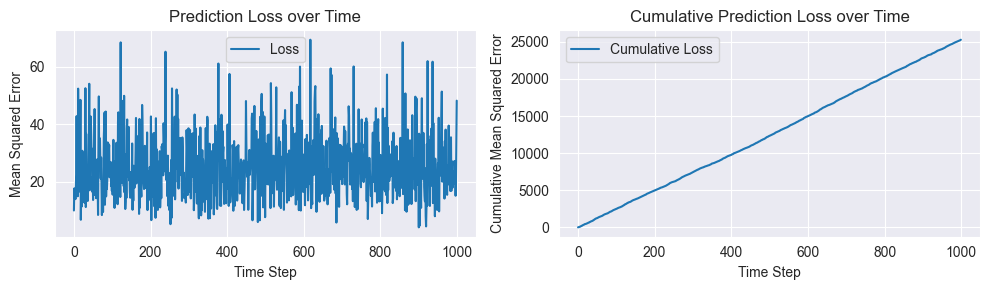

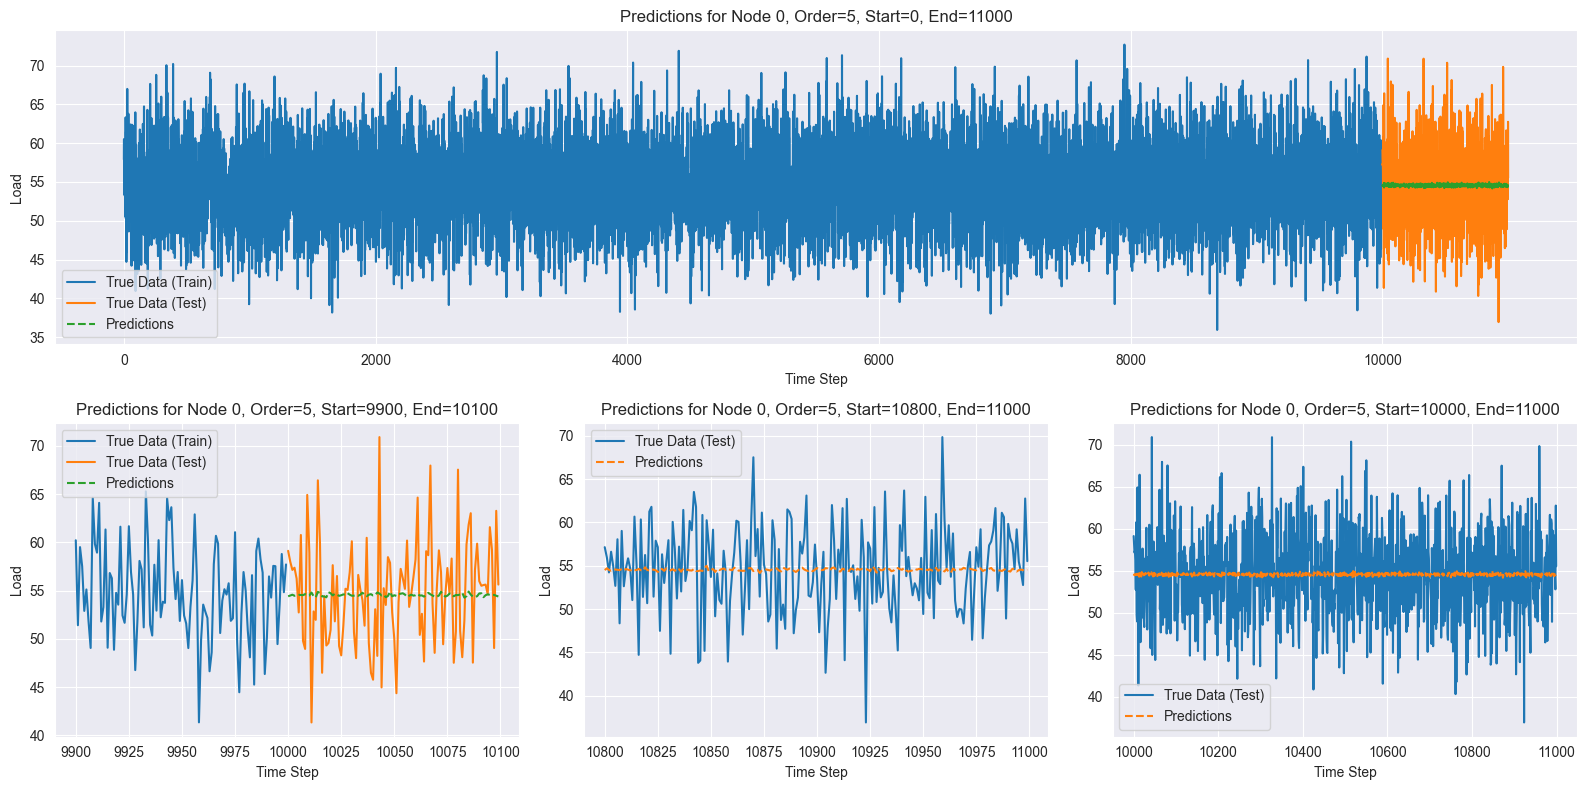

In [32]:
iid_load_ar_expert = test_AR_expert(iid_load_data_manager, 'iid_load')

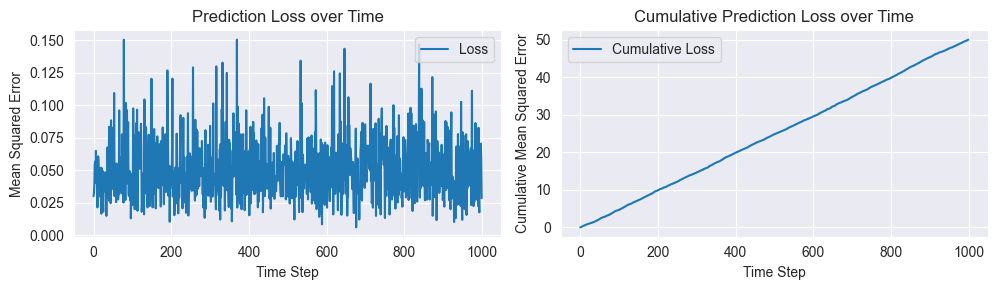

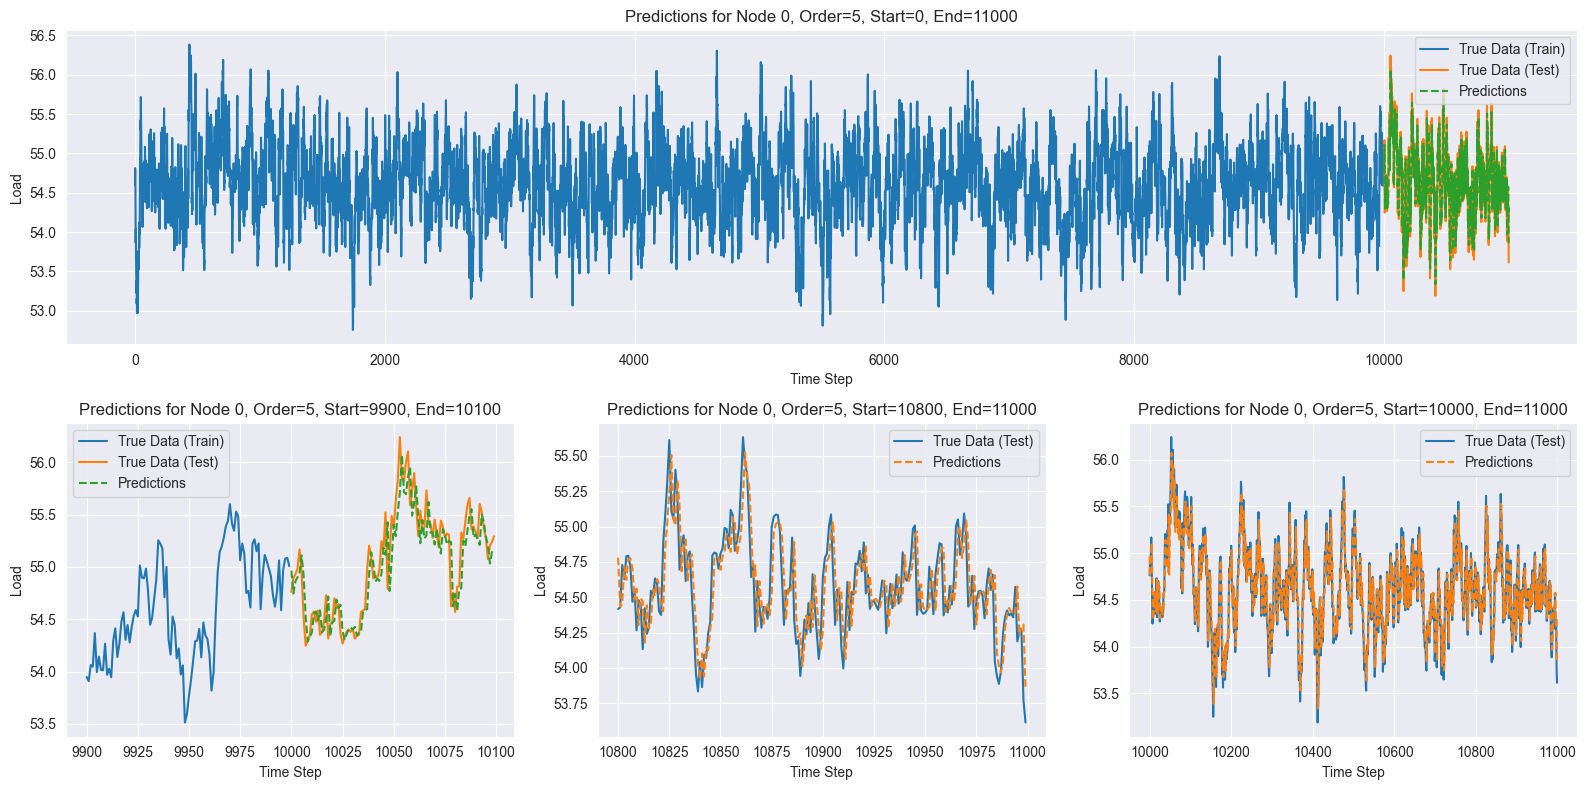

In [33]:
ar1_load_ar_expert = test_AR_expert(ar1_load_data_manager, 'ar1_load')

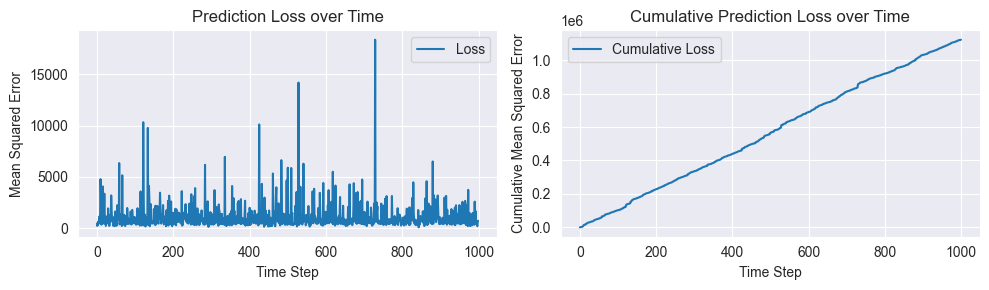

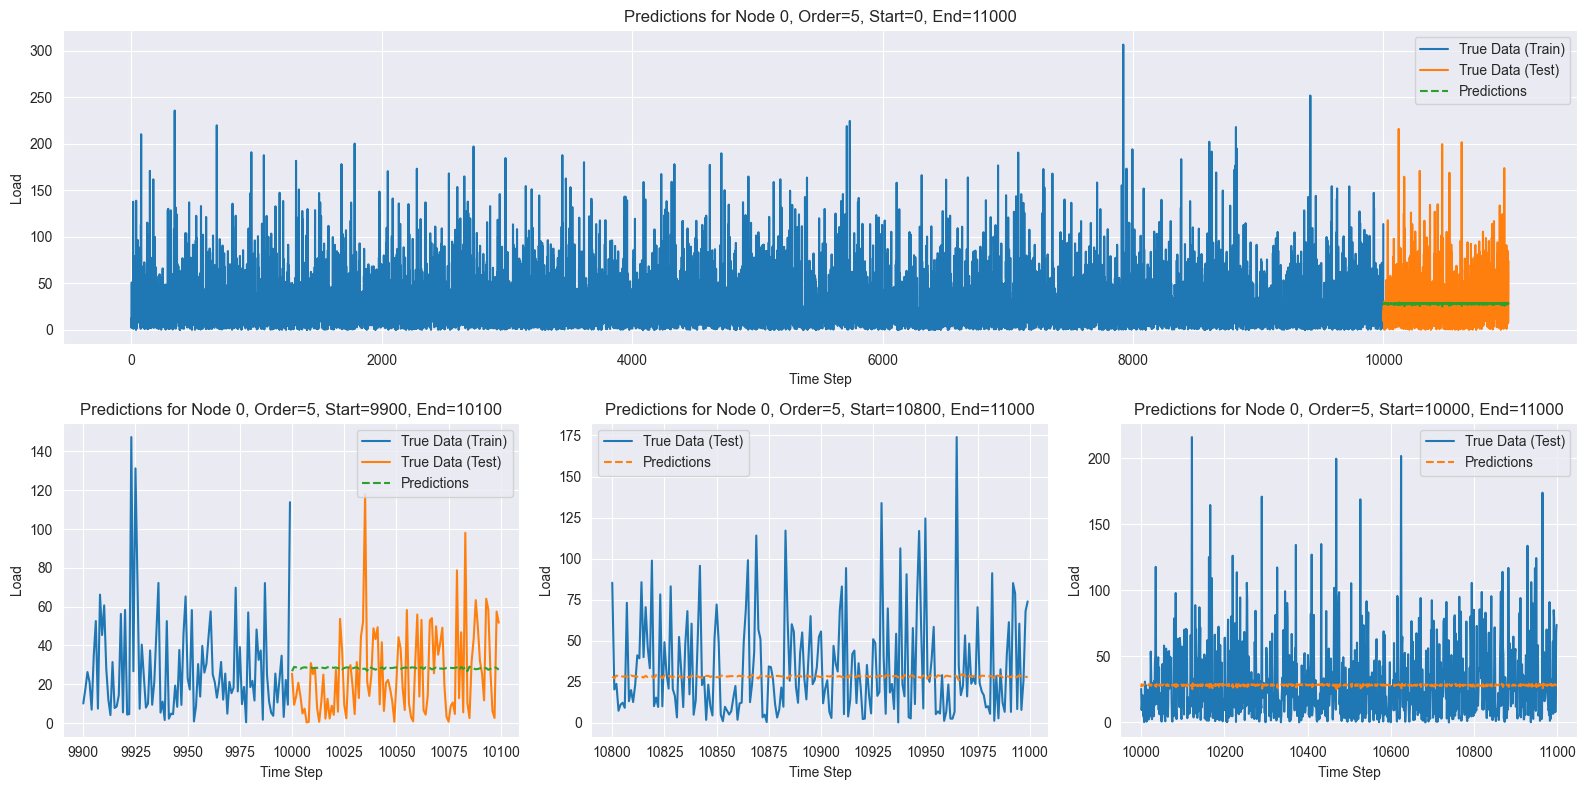

In [34]:
iid_latency_ar_expert = test_AR_expert(iid_latency_data_manager, 'iid_latency')

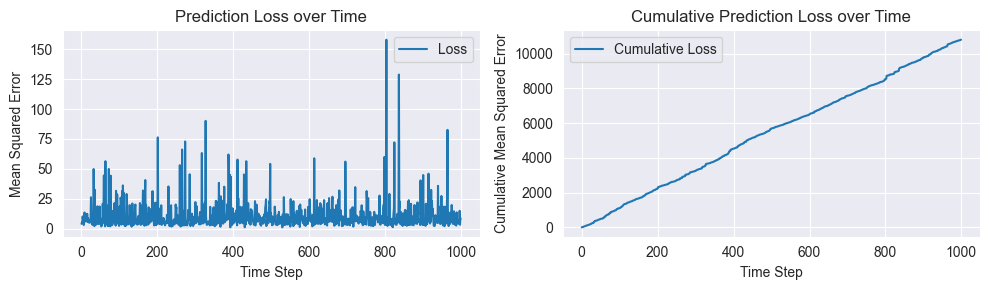

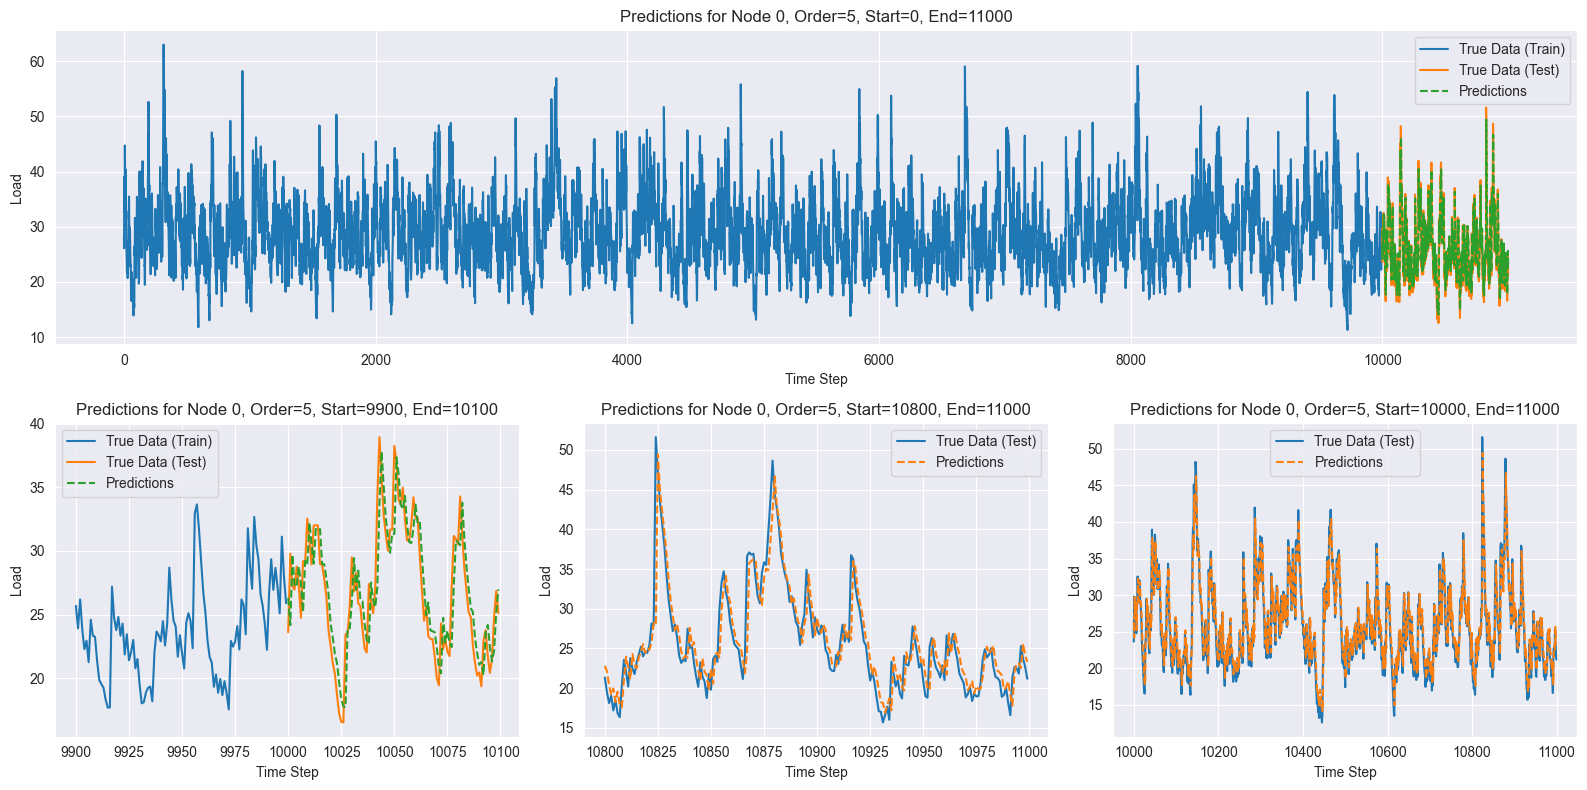

In [35]:
ar1_latency_ar_expert = test_AR_expert(ar1_latency_data_manager, 'ar1_latency')